In [1]:
# https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 897781.97it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135042.81it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274033.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5557330.45it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [58]:
# 디바이스를 cuda, cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [59]:
from torchvision import transforms
# 이미지를 정규화(Normalize)
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [60]:
train_ratio = 0.8
train_size = int(len(training_data) * 0.8)
valid_size = len(training_data) - train_size

print(train_size, valid_size)

48000 12000


In [61]:
from torch.utils.data import random_split

train_dataset, valid_dataset = random_split(training_data, [train_size, valid_size])

In [62]:
from torch.utils.data import DataLoader
# 데이토 로더에 넣기
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [63]:
#
for images, labels in test_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


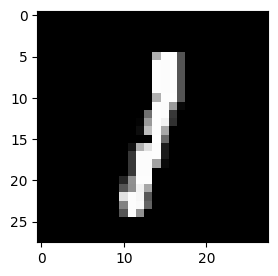

1


In [64]:
# 이미지를 시각화
import random
idx = random.randint(0, 63)
plt.figure(figsize=(3, 3))
plt.imshow(images[idx].squeeze(), cmap="gray")
plt.show()
print(labels[idx].item())

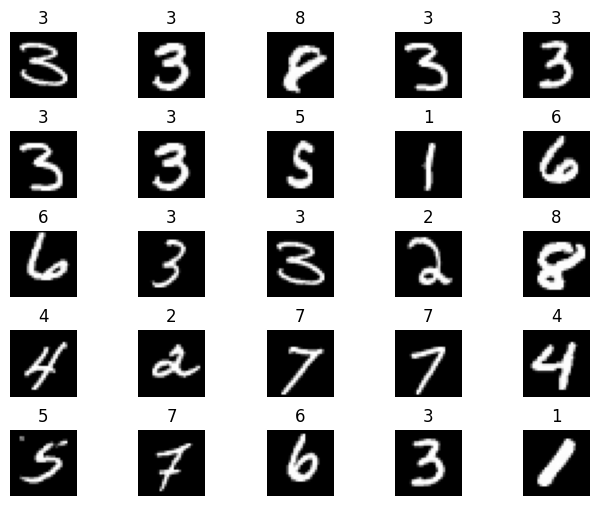

In [65]:
# nxn으로 이미지를 출력
n = 5

fig = plt.figure(figsize=(8, 8))
for i in range(n*n):
    idx = random.randint(0, 63)
    fig.add_subplot(n, n, i+1)
    plt.imshow(images[idx].squeeze(), cmap="gray")
    plt.title(labels[idx].item())
    plt.axis("off")


# 하단공간을 늘리기위해 추가
plt.subplots_adjust(hspace=0.5, bottom=0.3)

plt.show()

In [66]:
from collections import Counter

label = training_data.targets

class_count = Counter(label.numpy())
num_classes = len(class_count)

print(f"Number of classes: {num_classes}")
print(f"Class counts: {class_count}")


Number of classes: 10
Class counts: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [67]:
train_ratio = 0.8
train_size = len(training_data) * 0.8
valid_size = len(training_data) - train_size

print(train_size, valid_size)

48000.0 12000.0


In [68]:
import torch.nn as nn
import torch.nn.functional as F

In [69]:
# 신경망 모델 정의
inputNode = 28 * 28 # 이미지의 픽셀 갯수
hiddenNode1 = 512
hiddenNode2 = 256
outputNode = 10 #(0~9)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 입력 레이어 -> 첫 번째 중간 레이어
        self.fc2 = nn.Linear(512, 256)      # 첫 번째 중간 레이어 -> 두 번째 중간 레이어
        self.fc3 = nn.Linear(256, 10)       # 두 번째 중간 레이어 -> 출력 레이어 (10개 클래스)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 입력 이미지를 일렬로 펴서 28*28=784 크기의 벡터로 변환
        x = F.relu(self.fc1(x))  # 첫 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = F.relu(self.fc2(x))  # 두 번째 중간 레이어에서 ReLU 활성화 함수 적용
        x = self.fc3(x)          # 출력 레이어
        return x

In [70]:
lr = 0.001

# 훈련
# 가속을 위해 신경망을 GPU에서 구성
model = Net().to(device)
# 다중 분류를 위한 손실계산 함수
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [71]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [72]:
def train(dataloader, model, loss_fn, optimizer):
    train_correct =0
    train_total =0

    # 신경망의 모드를 훈련모드로 설정
    model.train()

    # 매 batch마다 loss를 누적
    train_loss = 0.0

    # batch사이즈만큼 이미지와 레이블을 가져와서
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 기울기 0으로 초기화
        optimizer.zero_grad()

        # 이미지로 추론해서 예측값 출력
        y_pred = model(images)

        # 손실값 계산
        loss = loss_fn(y_pred, labels)
        # 오차 역전파법으로 경사하강법, 기울기 구하기
        loss.backward()

        # 실제 W,b값 업데이트하기
        optimizer.step() # W_new = W_old - lr*grad(w)

        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # loss값 누적하기
        train_loss += loss.item()

    train_loss_list.append(train_loss)
    train_acc = (train_correct/train_total)*100
    train_acc_list.append(train_acc)

    return train_loss

In [73]:
def valid(dataloader, model, loss_fn):
    # 신경망의 모드를 평가모드로 설정
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    # 기울기를 구하지 않는다.
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss_list.append(valid_loss)
    valid_acc = (correct/total)*100
    valid_acc_list.append(valid_acc)

    accuracy = 100 * correct / total
    return valid_loss, accuracy


In [74]:
epochs = 20

for epoch in range(epochs):
    # 매 epoch마다 파라메터(가중치) 학습
    train_loss = train(train_loader, model, loss_fn, optimizer)
    # 매 epoch마다 loss값을 출력
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader)}")

    valid_loss, val_acc = valid(valid_loader, model, loss_fn)
    print(f"Valid Loss: {valid_loss / len(valid_loader)}, Accuracy: {val_acc}%")

Epoch 1/20, Train Loss: 1.609307876718578
Valid Loss: 0.7083670287690265, Accuracy: 83.53333333333333%
Epoch 2/20, Train Loss: 0.5103250422012577
Valid Loss: 0.4155487651203541, Accuracy: 88.725%
Epoch 3/20, Train Loss: 0.3792189040195459
Valid Loss: 0.34970035566452967, Accuracy: 90.125%
Epoch 4/20, Train Loss: 0.3353539885583717
Valid Loss: 0.3186215131365238, Accuracy: 90.80833333333334%
Epoch 5/20, Train Loss: 0.3076523077338616
Valid Loss: 0.29494265427297733, Accuracy: 91.575%
Epoch 6/20, Train Loss: 0.2866025006196011
Valid Loss: 0.2739810164463013, Accuracy: 92.16666666666667%
Epoch 7/20, Train Loss: 0.2677400990494533
Valid Loss: 0.2553302331807766, Accuracy: 92.73333333333333%
Epoch 8/20, Train Loss: 0.25092965180177423
Valid Loss: 0.23992063485561532, Accuracy: 93.03333333333333%
Epoch 9/20, Train Loss: 0.23499046946004
Valid Loss: 0.22463601415461681, Accuracy: 93.625%
Epoch 10/20, Train Loss: 0.2202409669192933
Valid Loss: 0.20915443252058738, Accuracy: 94.075%
Epoch 11/20

In [75]:
len(train_loss_list)

20

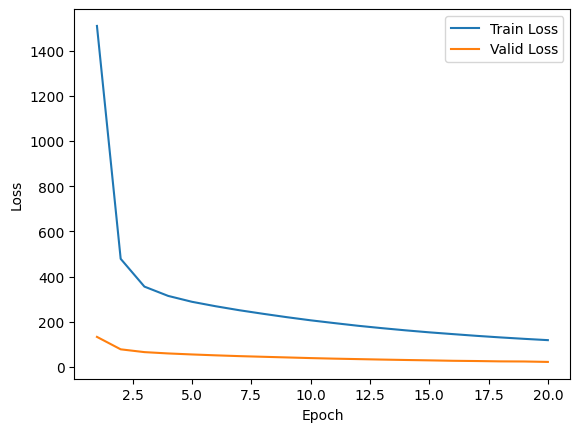

In [76]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1,epochs+1), valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

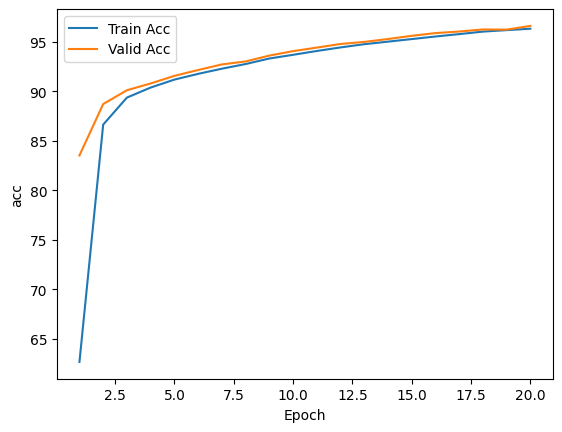

In [77]:
plt.figure()
plt.plot(range(1,epochs+1), train_acc_list, label='Train Acc')
plt.plot(range(1,epochs+1), valid_acc_list, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()
plt.show()